In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.data import read_merged
from seminartools.data import read_inflation

# 1. Read data

In [3]:
df = read_merged().reset_index()
df

,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [5]:
from seminartools.models.utils import get_stats
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.time_series_split import ExpandingWindowSplit

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("random_effects_1_lag", lambda: RandomEffectsModel()),
        ("random_effects_2_lag", lambda: RandomEffectsModel(lags = 2)),
        ("distance_1_lag", lambda: DistanceModel()),
        ("distance_2_lag", lambda: DistanceModel(lags = 2)),
    ],
    df,
    ExpandingWindowSplit(
        start_date = "2010-01-01",
        num_splits = 1,
    ),
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Creating regression coefficients: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


,mse,mae,r2,mz_intercept,mz_slope,mz_r2
ar,0.000061,0.005498,0.257578,0.000078,0.945370,0.259382
random_effects_1_lag,0.000078,0.006256,0.063156,0.001650,0.669709,0.089391
distance_1_lag,0.000078,0.006181,0.055320,0.002124,0.614731,0.095158
random_effects_2_lag,0.000081,0.006311,0.023584,0.002787,0.549409,0.072175
distance_2_lag,0.000082,0.006398,0.009101,0.002949,0.517089,0.073090


In [7]:
subdf = df.query("date <= '2010-01-01'")
model_ar = ARMAXModel(max_p=2, max_q=0)
model_ar.fit(df)
model_re = RandomEffectsModel(lags = 2)
model_re.fit(df)
model_distance = DistanceModel(lags = 2)
model_distance.fit(df)

Creating regression coefficients: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


# Compare coefficients

In [8]:
import arviz as az
from tqdm import tqdm

def get_params(country):
    params_ar = model_ar.models[country].params
    out = {
        "const": params_ar["const"],
    }
    for lag in range(1, len(model_ar.models[country].params) - 1):
        out[f"L{lag}"] = params_ar[f"ar.L{lag}"]
    params_ar = pd.Series(out)
    params_re = az.summary(model_re.results.posterior, round_to = 6)
    out = {
        "const": params_re.loc["Intercept", "mean"] + params_re.loc[f"1|country[{country}]", "mean"]
    }
    for i in range(1, model_re.lags + 1):
        out[f"L{i}"] = params_re.loc[f"inflation_lag_{i}|country[{country}]", "mean"]
    params_re = pd.Series(out)
    country_idx = model_distance.countries.tolist().index(country)
    params_distance = az.summary(model_distance.trace.posterior, round_to = 6)
    params_distance.index
    out = {
        "const": params_distance.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_distance.lags + 1):
        out[f"L{lag}"] = params_distance.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]

    params_distance = pd.Series(out)
    params = pd.concat([
        params_ar,
        params_re,
        params_distance,
    ], axis=1, keys=["ar", "re", "distance"])
    return params

params = pd.concat([
    get_params(country)
    for country in tqdm(model_distance.countries)
], keys=model_distance.countries, axis=0)
params

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


ar        re  distance
Japan          const  0.004101  0.001862 -0.213711
               L1     0.118208  0.026970  0.025848
               L2     0.491070  0.421927  0.454239
Canada         const  0.008751  0.002798  0.053553
               L1     0.661472  0.558445  0.583440
               L2          NaN  0.104440  0.092258
United States  const  0.009041  0.003751  0.096171
               L1     0.607577  0.596097  0.622189
               L2          NaN -0.020779 -0.036853
Australia      const  0.010533  0.002952  0.104862
               L1     0.396042  0.388765  0.393566
               L2     0.334930  0.323146  0.332821
New Zealand    const  0.006604  0.003206 -0.033617
               L1     0.392667  0.345379  0.366021
               L2     0.159205  0.142582  0.150066
Switzerland    const  0.002077  0.000821 -0.410746
               L1     0.166873 -0.033830  0.102735
               L2     0.378784  0.182184  0.284497
Italy          const  0.005325  0.002464 -0.068868
               L1     0.380128  0.354352  0.361537
               L2     0.209207  0.185293  0.230811
France         const  0.004011  0.002781 -0.184175
               L1     0.282443  0.210980  0.206407
               L2          NaN  0.123967  0.207439
Portugal       const  0.005424  0.003466 -0.110717
               L1    -0.105373 -0.107451 -0.104828
               L2     0.478116  0.451767  0.480713
Spain          const  0.005630  0.003327 -0.070341
               L1    -0.145436 -0.154011 -0.143119
               L2     0.604190  0.579035  0.608125
Sweden         const  0.005413  0.001716 -0.058763
               L1     0.229703  0.238162  0.246251
               L2     0.503438  0.430706  0.469237
Denmark        const  0.004977  0.003183 -0.141950
               L1     0.420547  0.387720  0.440028
               L2          NaN -0.040910 -0.063770
United Kingdom const  0.004941  0.004249 -0.174364
               L1    -0.113999 -0.099007 -0.037158
               L2     0.267834  0.223109  0.245829
Germany        const  0.005153  0.003161 -0.122144
               L1     0.392778  0.410421  0.513926
               L2          NaN -0.032543 -0.094295
Netherlands    const  0.005592  0.004167 -0.107965
               L1     0.440415  0.402916  0.428792
               L2    -0.191803 -0.161920 -0.154785
Norway         const  0.005845  0.005784 -0.130084
               L1    -0.000540  0.003453  0.005212
               L2          NaN -0.018354 -0.021628
Belgium        const  0.005727  0.003197 -0.089760
               L1     0.469651  0.400323  0.420600
               L2          NaN  0.049945  0.022862
Korea          const  0.006165  0.004741 -0.055950
               L1     0.104963  0.098318  0.101424
               L2     0.156239  0.132341  0.157324
South Africa   const  0.013459  0.009795  0.637486
               L1     0.282654  0.221571  0.182180
               L2          NaN  0.003085 -0.071678
Türkiye        const  0.023856  0.016685  1.629640
               L1     0.067917  0.136497  0.078312
               L2          NaN  0.137561  0.083480

In [11]:
import seaborn as sns

#cm = sns.light_palette("pink", as_cmap=True)
# get coolwarm cmap
cm = sns.color_palette("coolwarm", as_cmap=True)
params.style.background_gradient(cmap=cm)



# Compare forecasts

pred_ar   pred_re  pred_distance
date       country                                         
2010-01-01 Japan         -0.000517  0.001779       0.001596
           Canada         0.004423  0.004230       0.004007
           United States  0.004770  0.007579       0.007475
           Australia      0.008212  0.008061       0.007950
           New Zealand    0.004304  0.008475       0.008586
...                            ...       ...            ...
2023-01-01 Norway         0.005842  0.005421       0.005439
           Belgium        0.017570  0.014052       0.013941
           Korea          0.006746  0.008612       0.009037
           South Africa   0.012052  0.016062       0.015024
2021-01-01 Türkiye        0.025702  0.024056       0.024228

[1060 rows x 3 columns]

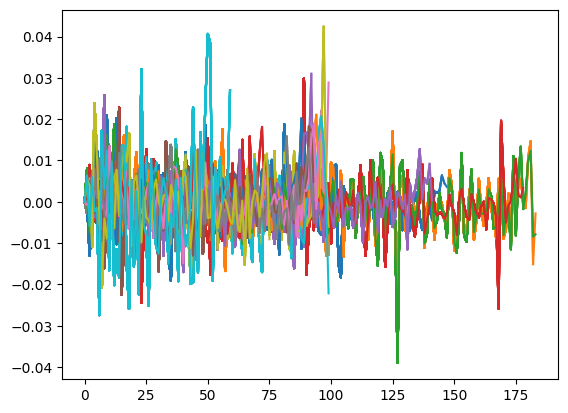

In [45]:
from seminartools.models.utils import h_period_ahead_forecast

preds = pd.concat(
    [
        h_period_ahead_forecast(
            model,
            df,
            h=1,
            start_date="2010-01-01",
        )
        .set_index(["date", "country"])["inflation"].rename(f"pred_{name}")
        #.rename(columns = {"inflation": f"pred_{name}"})
        for model, name in [
            (model_ar, "ar"),
            (model_re, "re"),
            (model_distance, "distance"),
        ]
    ], axis=1
)
preds

In [46]:
merged = preds.merge(df[["inflation", "date", "country"]], left_index=True, right_on = ["date", "country"]).set_index(["date", "country"]).dropna()
merged

pred_ar   pred_re  pred_distance  inflation
date       country                                                    
2010-01-01 Japan         -0.000517  0.001779       0.001596   0.000000
           Canada         0.004423  0.004230       0.004007   0.004405
           United States  0.004770  0.007579       0.007475   0.004014
           Australia      0.008212  0.008061       0.007950   0.009132
           New Zealand    0.004304  0.008475       0.008586   0.003659
...                            ...       ...            ...        ...
2023-01-01 Netherlands    0.002497  0.016483       0.017581  -0.013667
           Norway         0.005842  0.005421       0.005439   0.006886
           Belgium        0.017570  0.014052       0.013941  -0.003628
           Korea          0.006746  0.008612       0.009037   0.010538
           South Africa   0.012052  0.016062       0.015024   0.011202

[1016 rows x 4 columns]

In [49]:
from sklearn.metrics import mean_squared_error

for col in ["pred_ar", "pred_re", "pred_distance"]:
    print(f"{col}: {mean_squared_error(merged['inflation'], merged[col]):.2g}")

pred_ar: 4.9e-05
pred_re: 7.5e-05
pred_distance: 7.6e-05
